# Project: 
Sentiment Orientation Identification using Multinomial Naive Bayes and
Logistic Regression

Xiaoyue Lin

# 1. The training-evaluation phase

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
import pickle
from scipy.sparse import vstack
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from collections import Counter

In [2]:
def preprocess(reviews):
    '''This pre-processing function makes a review text case-insensitive, removes punctuation,
    removes stop words, removes single characters, lemmatizes words.'''

    # convert reviews to lower case
    reviews = reviews.str.lower()

    # initialize lemmatizer and a list of stopwords
    lemmatizer = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
    all_stopwords = lemmatizer.Defaults.stop_words
    
    for i in range(len(reviews)):
        rev = reviews[i]
        # remove punctuations and numbers
        symbols = ",!\"#$%&()*+-./:;<=>?@[\]^_`{|}~0123456789"
        for sym in symbols:
            rev = np.char.replace(rev, sym, ' ')

        # remove stop words and single characters
        rev_tokens = word_tokenize(str(rev))
        tokens_without_sw = " ".join([word for word in rev_tokens if (word not in all_stopwords) and (len(word) > 1)])

        # remove ’
        tokens_without_sw = np.char.replace(tokens_without_sw, "'", ' ')
        
        # spaCy Lemmatization
        doc = lemmatizer(str(tokens_without_sw))
        reviews[i] = " ".join([token.lemma_ for token in doc]) # Extract the lemma for each token and join
    return reviews

In [3]:
def draw_cm(y_true, y_pred, title):
    '''This function draws a confusion matrix'''
    cm = confusion_matrix(y_true, y_pred, labels = [1, 3, 5], normalize = 'true')
    df_cm = pd.DataFrame(cm, columns=['Negative', 'Neutral', 'Postive'], index = ['Negative', 'Neutral', 'Postive'])
    df_cm.index.name = 'Actual rating'
    df_cm.columns.name = 'Predicted rating'
    plt.figure(figsize = (10, 7))
    plt.title(title)
    sn.heatmap(df_cm, annot = True, cmap='Blues')

In [13]:
# Load in data

train_review_table = pd.read_csv(r"review_text_train.csv", index_col = False, delimiter = ',',
                                 header = 0)
train_corpus = train_review_table['review']  # instances
print('num of training instances: ', len(train_corpus))
vocab = pickle.load(open(r".\review_text_features_countvec\train_countvectorizer.pkl", "rb"))
vocab_dict = vocab.vocabulary_ # access the list of vocabulary
print("num of distinct words in training：", len(vocab_dict)) # num of distinct words in training ins

train_meta_table = pd.read_csv(r"review_meta_train.csv", index_col = False, header = 0)
ratings = train_meta_table['rating']
votes = train_meta_table[['vote_funny', 'vote_cool', 'vote_useful']]

test_review_table = pd.read_csv(r"review_text_test.csv", index_col = False, delimiter = ',', header = 0)
X_test_reviews = test_review_table['review']
test_meta_table = pd.read_csv(r"review_meta_test.csv", index_col = False, header = 0)
votes_test = test_meta_table[['vote_funny', 'vote_cool', 'vote_useful']]

num of training instances:  28068
num of distinct words in training： 41648


In [5]:
Counter(ratings) # counting each label

Counter({1: 2336, 5: 19288, 3: 6444})

In [6]:
# pre-processing

train_corpus_tidy = preprocess(train_corpus)
text_corpus_tidy = preprocess(X_test_reviews)

In [7]:
train_corpus.head(5)

0    dear longman & eagle.......you've left me no c...
1    Delish. The hubby and I wanted to do brunch on...
2    yep, I've giving Yolk 5 stars. It's just reall...
3    Meat, meat, meat. It's meat-tastic. So much me...
4    I caught up with the law school girls on a Sat...
Name: review, dtype: object

In [8]:
train_corpus_tidy.head(5)

0    dear longman eagle leave choice idea menu look...
1    delish hubby want brunch sunday think longman ...
2    yep give yolk star good service friendly effic...
3    meat meat meat meat tastic meat age mad cow li...
4    caught law school girl saturday yolk quick bre...
Name: review, dtype: object

In [16]:
def train_test(model, ks, X_train, votes_train, y_train, X_valid, votes_valid, y_valid, ngrams, print_feat):
    '''This function trains and tests model.'''
    
    n_ks = len(ks)
    
    # Vectorizing data
    vectorizer = CountVectorizer(stop_words = 'english',
                                 lowercase = True,  ngram_range = ngrams)
    X_train_vec = vectorizer.fit_transform(X_train)
    #print("number of distinct words in training set after preprocessing:", X_train_vec.shape[1])
    X_valid_vec = vectorizer.transform(X_valid)
    #print(X_valid_vec.shape)

    # Chi-square feature selection
    Xs = [] # a set of training and validation pairs
    vec_0_ind_ks = [] # indices of zero vectors
    y_valid_pred1_ks = []
    for k in ks:
        if k != 'complete':
            chisq = SelectKBest(chi2, k = k)
            X_train_selected = chisq.fit_transform(X_train_vec, y_train)
            X_valid_selected = chisq.transform(X_valid_vec)
        else:
            X_train_selected = X_train_vec # selection is skipped if all features are required
            X_valid_selected = X_valid_vec
            
        n_valid = X_valid_selected .shape[0]
        vec_0_ind = [] # indices of zero vectors
        n_zero_vec = 0  # num of zero vectors
        for i in range(n_valid):
            if X_valid_selected[i - n_zero_vec].sum(axis = 1) == 0:
                X_valid_selected = vstack(
                    [X_valid_selected[:(i - n_zero_vec), :], X_valid_selected[(i - n_zero_vec) + 1:, :]])
                vec_0_ind.append(X_valid.index[i])
                n_zero_vec += 1
        #print('\nnumber of zero vec: ', n_zero_vec, '\n')
        vec_0_ind_ks.append(vec_0_ind)
        
        # save training and validation pairs
        X = (X_train_selected, X_valid_selected)
        Xs.append(X)

        # predict zero vectors based on votes
        y_valid_pred1 = []
        if vec_0_ind:
            clf_vote = MultinomialNB()
            clf_vote.fit(votes_train, y_train)
            y_valid_pred1 = clf_vote.predict(votes_valid.ix[vec_0_ind])
            y_valid_pred1_ks.append(y_valid_pred1)

        # print a sample of selected feature if print_feat is True
        if print_feat:
            for feat_num in chisq.get_support(indices = True):
                print(
                    vectorizer.get_feature_names()[feat_num])
            print_feat = False

    Xs_names = ['chi-square with k = ' + str(k) for k in ks]
    
    # test performance on validation
    accuracies = []
    for n in range(n_ks):
        X_train_t, X_test_t = Xs[n]
        model.fit(X_train_t, y_train)
        y_valid_pred2 = model.predict(X_test_t)

        # combine two lists of predicted labels
        for j in range(len(vec_0_ind_ks[n])):
            ind_valid = vec_0_ind_ks[n][j]
            pred_valid = y_valid_pred1_ks[n][j]
            ind_cls = 0 # order in predicted class
            for ind in X_valid.index:
                if ind == ind_valid:
                    y_valid_pred2 = np.insert(y_valid_pred2, ind_cls, pred_valid)
                ind_cls += 1
        
        # if y_valid is None, this is classifying the test set; else, calculate the accuracy
        if any(y_valid):        
            acc = accuracy_score(y_true = y_valid, y_pred = y_valid_pred2)
            #print(Xs_names[n], acc)
            accuracies.append(acc)

    return accuracies, y_valid_pred2

In [10]:
# cross-validation

kFolds = 5
skf = StratifiedKFold(kFolds, shuffle = True, random_state = 7)  # todo try diff rand_state
X_train_folds = []
votes_train_folds = []
y_train_folds = []
X_valid_folds = []
votes_valid_folds = []
y_valid_folds = []
for train_index, test_index in skf.split(X = train_corpus_tidy, y = ratings):
    X_train_folds.append(train_corpus_tidy[train_index])
    votes_train_folds.append(votes.iloc[train_index, :])
    y_train_folds.append(ratings[train_index])
    X_valid_folds.append(train_corpus_tidy[test_index])
    votes_valid_folds.append(votes.iloc[test_index, :])
    y_valid_folds.append(ratings[test_index])


In [17]:
# tuning k on MNB_(1, 1)

ks = [1000, 2000, 5000, 10000, 20000, 25000, 30000, 'complete']
n_ks = len(ks)
accuracies = np.zeros(n_ks)  
for f in range(kFolds):
    acc, y_pred = train_test(MultinomialNB(), ks, X_train_folds[f], votes_train_folds[f], y_train_folds[f], 
                     X_valid_folds[f], votes_valid_folds[f], y_valid_folds[f], ngrams = (1, 1), print_feat = False)
    for k in range(n_ks):
        accuracies[k] += acc[k] / kFolds

In [18]:
accuracies # mnb_(1, 1)

array([0.82431946, 0.82496083, 0.82795347, 0.83069684, 0.83322645,
       0.83351142, 0.83276322, 0.83244254])

In [19]:
# tuning k on MNB_(1, 2)

ks = [1000, 2000, 5000, 10000, 20000, 25000, 30000, 'complete']
n_ks = len(ks)
accuracies = np.zeros(n_ks)  
for f in range(kFolds):
    acc, y_pred = train_test(MultinomialNB(), ks, X_train_folds[f], votes_train_folds[f], y_train_folds[f], 
                     X_valid_folds[f], votes_valid_folds[f], y_valid_folds[f], ngrams = (1, 2), print_feat = False)
    for k in range(n_ks):
        accuracies[k] += acc[k] / kFolds

In [20]:
accuracies # mnb_(1, 2)

array([0.82513903, 0.82998421, 0.83422408, 0.83967526, 0.84003142,
       0.83732371, 0.83233581, 0.71932434])

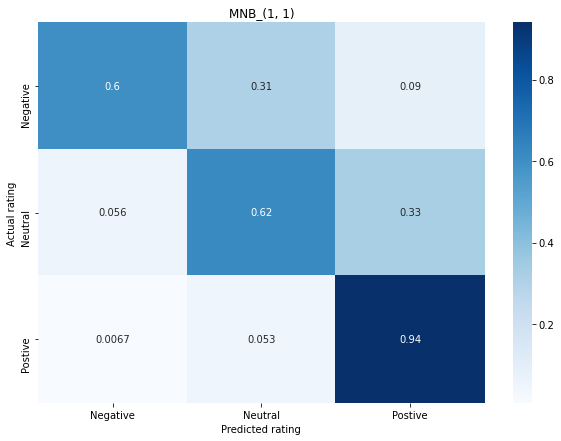

In [21]:
# mnb_(1, 1)
# tune the k to the optimal value = 25000
ks = [25000]
f = 0 # fold index
acc, y_pred = train_test(MultinomialNB(), ks, X_train_folds[f], votes_train_folds[f], y_train_folds[f], 
                     X_valid_folds[f], votes_valid_folds[f], y_valid_folds[f], ngrams = (1, 1), print_feat = False)

draw_cm(y_valid_folds[f], y_pred, 'MNB_(1, 1)')

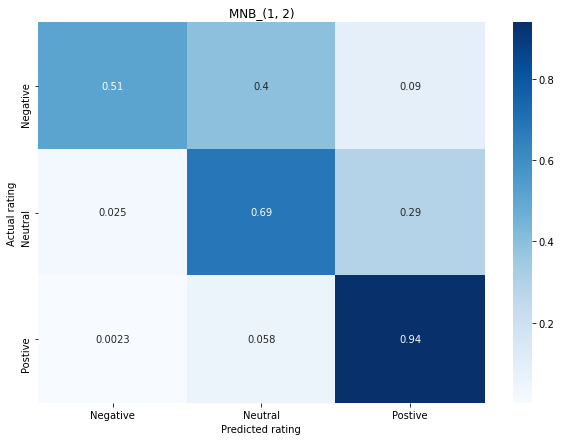

In [22]:
# mnb_(1, 2)
# tune the k to the optimal value = 20000
ks = [20000]
f = 0
acc, y_pred = train_test(MultinomialNB(), ks, X_train_folds[f], votes_train_folds[f], y_train_folds[f], 
                     X_valid_folds[f], votes_valid_folds[f], y_valid_folds[f], ngrams = (1, 2), print_feat = False)

draw_cm(y_valid_folds[f], y_pred, 'MNB_(1, 2)')

In [23]:
# tuning k on lgr_(1, 1)
ks = [1000, 2000, 5000, 10000, 20000, 25000, 30000, 'complete']
n_ks = len(ks)
accuracies = np.zeros(n_ks)  
for f in range(kFolds):
    acc, y_pred = train_test(LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter=1000), ks, X_train_folds[f], votes_train_folds[f], y_train_folds[f], 
                     X_valid_folds[f], votes_valid_folds[f], y_valid_folds[f], ngrams = (1, 1), print_feat = False)
    for k in range(n_ks):
        accuracies[k] += acc[k] / kFolds

In [24]:
accuracies # lgr_(1, 1)

array([0.83458003, 0.835079  , 0.83436635, 0.83276306, 0.83155156,
       0.8309102 , 0.83123085, 0.83066081])

In [26]:
# tuning k on lgr_(1, 2)
ks = [1000, 2000, 5000, 10000, 20000, 25000, 30000, 'complete']
n_ks = len(ks)
accuracies = np.zeros(n_ks)  
for f in range(kFolds):
    acc, y_pred = train_test(LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter=1000), ks, X_train_folds[f], votes_train_folds[f], y_train_folds[f], 
                     X_valid_folds[f], votes_valid_folds[f], y_valid_folds[f], ngrams = (1, 2), print_feat = False)
    for k in range(n_ks):
        accuracies[k] += acc[k] / kFolds

In [27]:
accuracies # lgr_1, 2)

array([0.83675348, 0.84152764, 0.84245382, 0.84224014, 0.84270335,
       0.84252525, 0.84245399, 0.84925869])

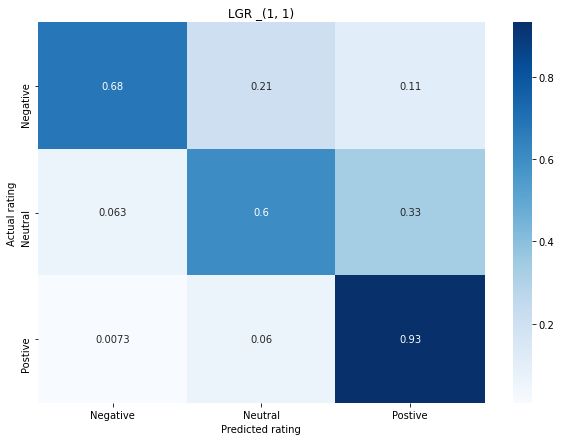

In [28]:
# lgr_(1, 1)
# tune the k to the optimal value = 2000

ks = [2000]
f = 0
acc, y_pred = train_test(LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter=1000), ks, 
                         X_train_folds[f], votes_train_folds[f], y_train_folds[f], 
                     X_valid_folds[f], votes_valid_folds[f], y_valid_folds[f], ngrams = (1, 1), print_feat = False)

draw_cm(y_valid_folds[f], y_pred, 'LGR _(1, 1)')

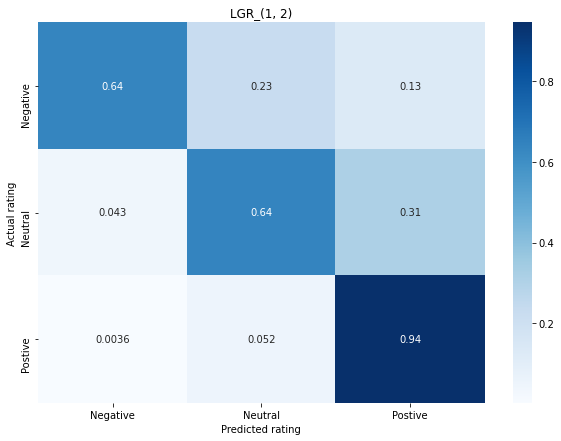

In [29]:
# lgr
# tune the k to the optimal value = 'complete'

ks = ['complete']
f = 0
acc, y_pred = train_test(LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter=1000), ks, 
                         X_train_folds[f], votes_train_folds[f], y_train_folds[f], 
                     X_valid_folds[f], votes_valid_folds[f], y_valid_folds[f], ngrams = (1, 2), print_feat = False)

draw_cm(y_valid_folds[f], y_pred, 'LGR_(1, 2)')

# 2. The test phase

In [30]:
get_csv = False # if csv output is needed

In [31]:
# Predict the classlabel of the test set
# using mnb_(1, 1), k = 25000
if get_csv:
    final_model = MultinomialNB()
    ks = [25000]
    acc, y_pred = train_test(final_model, ks, train_corpus_tidy, votes, ratings, text_corpus_tidy, 
                             votes_test, [], ngrams = (1, 1), print_feat = False)
    fname = "mnb_(1,1)_25000.csv"
    pd.DataFrame({'Instance_id': np.arange(1, 7019), 'rating': y_pred}).to_csv(fname, index = None)

In [32]:
# Predict the classlabel of the test set
# using mnb_(1, 2), k = 20000

if get_csv:
    final_model = MultinomialNB()
    ks = [20000]
    acc, y_pred = train_test(final_model, ks, train_corpus_tidy, votes,
               ratings, text_corpus_tidy, votes_test, [], ngrams = (1, 2), print_feat = False)
    fname = "mnb_(1,2)_20000.csv"
    pd.DataFrame({'Instance_id': np.arange(1, 7019), 'rating': y_pred}).to_csv(fname, index = None)

In [33]:
# Predict the classlabel of the test set
# using lgr_(1, 1), k = '2000'

if get_csv:
    final_model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter=1000)
    ks = [2000]
    acc, y_pred = train_test(final_model, ks, train_corpus_tidy, votes,
               ratings, text_corpus_tidy, votes_test, [], ngrams = (1, 1), print_feat = False)
    fname = "lgr_(1,1)_2000.csv"
    pd.DataFrame({'Instance_id': np.arange(1, 7019), 'rating': y_pred}).to_csv(fname, index = None)

In [34]:
# Predict the classlabel of the test set
# using lgr_(1, 2), k = 'complete'

if get_csv:
    final_model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter=1000)
    ks = ['complete']
    acc, y_pred = train_test(final_model, ks, train_corpus_tidy, votes,
               ratings, text_corpus_tidy, votes_test, [], ngrams = (1, 2), print_feat = False)
    fname = "lgr_(1,2)_complete.csv"
    pd.DataFrame({'Instance_id': np.arange(1, 7019), 'rating': y_pred}).to_csv(fname, index = None)